* rename ICA variables to match LCA variables

## Imports

In [1]:
#%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import os                                                                       
import scipy.optimize as opt
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             

## Model parameters

In [24]:
params = {                                                                      
  ## Model params                                                               
  "out_dir": os.path.expanduser("~")+"/Work/Projects/ICAstrongPCA/outputs/",       
  "chk_dir": os.path.expanduser("~")+"/Work/Projects/ICAstrongPCA/checkpoints/",
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/",
  "load_chk": False,                                                             
  "load_cov": False,
  "update_interval": 1000,                                                       
  "device": "/cpu:0",                                                           
  "prior": "laplacian",
  "learning_rate": 0.12,                                                        
  "num_neurons": int(16**2),                                                           
  "sparse_mult": 0.2,                                                           
  "num_inference_steps": 20,                                                    
  "eta": 0.001/0.03, #dt/tau                                                    
  "eps": 1e-12,                                                                 
  ## Data params                                                                
  "data_type": "vanhateren",                                                    
  "rand_state": np.random.RandomState(12345),                                   
  "num_images": 100,                                                          
  "num_batches": int(1e5), #Total dataset size is num_batches*batch_size
  "batch_size": 100,                                                            
  "patch_edge_size": 16,                                                        
  "overlapping_patches": True,                                                  
  "patch_variance_threshold": 1e-6,                                             
  "conv": False,                                                                
  "whiten_images": True,
  ## Pooling params
  "cov_num_images":int(1e7),
  "num_pooling_dims": 50, #K
  ## Visualization params
  "num_pooling_filters":50,
  "num_connected_weights":250}

## Calculated params                                                            
params["epoch_size"] = params["batch_size"] * params["num_batches"]             
params["num_pixels"] = int(params["patch_edge_size"]**2)                        
params["dataset_shape"] = [int(val)                                             
    for val in [params["epoch_size"], params["num_pixels"]]],                   
params["a_shape"] = [params["num_pixels"], params["num_neurons"]]             

## Functions for analysis

### Pooling filters function

In [4]:
def compute_pooling_filters(a_cov, num_pooling_dims):
  evals, evecs = np.linalg.eig(a_cov)
  sort_indices = np.argsort(evals)[::-1]
  top_vecs = evecs[sort_indices[:num_pooling_dims]]
  pooling_filters = np.dot(top_vecs.T, top_vecs)
  return pooling_filters

## Load dataset

In [ ]:
if not params["load_cov"] and not params["load_chk"]: 
  data = dp.get_data(params["data_type"], params)                                 
params["input_shape"] = [                                                       
  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

## Define graph

In [9]:
graph = tf.Graph()
with tf.device(params["device"]):
  with graph.as_default():
    with tf.name_scope("placeholders") as scope:
      x = tf.placeholder(tf.float32, shape=[None, params["num_pixels"]],
        name="input_data")

    with tf.name_scope("step_counter") as scope:
      global_step = tf.Variable(0, trainable=False, name="global_step")

    with tf.variable_scope("weights") as scope:
      ## Q matrix from QR decomp is guaranteed to be orthonormal and
      ## non-singular, which prevents a gradient explosion from inverting
      ## the weight matrix.
      Q, R = np.linalg.qr(np.random.standard_normal(params["a_shape"]))
      a = tf.get_variable(name="a", dtype=tf.float32,
        initializer=Q.astype(np.float32), trainable=True)

    with tf.name_scope("inference") as scope:
      u = tf.matmul(x, tf.matrix_inverse(a, name="a_inverse"),
        name="coefficients")
      if params["prior"] == "laplacian":
        z = tf.sign(u)
      else: #It must be laplacian or cauchy
        z = (2*u) / (1 + tf.pow(u, 2.0))

    with tf.name_scope("optimizers") as scope:
      learning_rates = tf.train.exponential_decay(
        learning_rate=params["learning_rate"],
        global_step=global_step,
        decay_steps=int(np.floor(params["num_batches"]*0.8)),
        decay_rate=0.5,
        staircase=True,
        name="a_annealing_schedule")
      optimizer = tf.train.GradientDescentOptimizer(learning_rates,
        name="a_optimizer")
      z_u_avg = tf.divide(tf.matmul(tf.transpose(u), z),                   
        tf.to_float(tf.shape(x)[0]), name="avg_samples")                        
      gradient = -tf.subtract(tf.matmul(z_u_avg, a), a, name="a_gradient")                                                
      update_weights = optimizer.apply_gradients([(gradient, a)],
        global_step=global_step)

    full_saver = tf.train.Saver(var_list=[a], max_to_keep=2)

    with tf.name_scope("summaries") as scope:
      #tf.summary.image("input", tf.reshape(x, [params["batch_size"],
      #  params["patch_edge_size"], params["patch_edge_size"], 1]))
      tf.summary.histogram("u", u)
      tf.summary.histogram("z", z)
      tf.summary.histogram("a", a)

    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(params["out_dir"], graph)

    with tf.name_scope("initialization") as scope:
      init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Train LCA model (if needed)

{'u_max': '8.177115440368652', 'z_frac_act': '1.0', 'current_step': '00001'}
{'u_max': '10.529738426208496', 'z_frac_act': '1.0', 'current_step': '00002'}
{'u_max': '7.24743127822876', 'z_frac_act': '1.0', 'current_step': '00003'}
{'u_max': '9.917510986328125', 'z_frac_act': '1.0', 'current_step': '00004'}
{'u_max': '8.215246200561523', 'z_frac_act': '1.0', 'current_step': '00005'}
{'u_max': '7.730742454528809', 'z_frac_act': '1.0', 'current_step': '00006'}
{'u_max': '9.559082984924316', 'z_frac_act': '1.0', 'current_step': '00007'}
{'u_max': '7.53985595703125', 'z_frac_act': '1.0', 'current_step': '00008'}
{'u_max': '8.6891508102417', 'z_frac_act': '1.0', 'current_step': '00009'}
{'u_max': '12.851539611816406', 'z_frac_act': '1.0', 'current_step': '00010'}
{'u_max': '8.539358139038086', 'z_frac_act': '1.0', 'current_step': '00011'}


SystemError: <built-in method write of _io.BufferedWriter object at 0x1109dbe08> returned a result with an error set

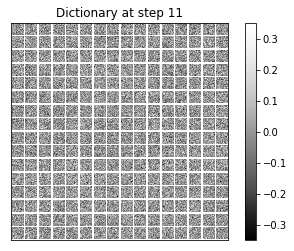

In [27]:
if not params["load_chk"]:
  if not os.path.exists(params["out_dir"]):
    os.makedirs(params["out_dir"])
  if not os.path.exists(params["chk_dir"]):
    os.makedirs(params["chk_dir"])

  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
    feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    
    sess.graph.finalize() # Graph is read-only after this statement.

    num_updates = np.int32(np.floor(params["num_batches"]/params["update_interval"]))
    batch_steps = [None]*num_updates
    sparsities = [None]*num_updates
    update_idx = 0
    for b_step in range(params["num_batches"]):
      input_data = data["train"].next_batch(params["batch_size"])[0]

      feed_dict = {x:input_data}

      sess.run(update_weights, feed_dict)

      current_step = sess.run(global_step)
      if (current_step % params["update_interval"] == 0):
        summary = sess.run(merged_summaries, feed_dict)
        train_writer.add_summary(summary, current_step)
        full_saver.save(sess, save_path=params["chk_dir"]+"ica_chk",
          global_step=global_step)
        [u_vals, z_vals, weights] = sess.run(
          [u, z, a], feed_dict)
        
        u_vals_max = np.array(u_vals.max()).tolist()
        z_frac_act = np.array(np.count_nonzero(z_vals)
          / float(params["batch_size"]*params["num_neurons"])).tolist()
        batch_steps[update_idx] = current_step
        sparsities[update_idx] = z_frac_act

        print_dict = {"current_step":str(current_step).zfill(5),
          "u_max":str(u_vals_max),
          "z_frac_act":str(z_frac_act)}
        print(print_dict)
        pf.save_data_tiled(weights.T.reshape((params["num_neurons"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Dictionary at step "+str(current_step),
          save_filename=(params["out_dir"]+"phi_"+str(current_step).zfill(5)
          +".png"))
        update_idx += 1
    output_data = {"batch_step":batch_steps, "frac_active":sparsities}
    pf.save_stats(output_data,
      save_filename=(params["out_dir"]+"train_stats.png"))

## Compute activity covariance & pooling filters

### Compute activity covariance matrix

In [ ]:
if params["load_cov"]:
  u_cov = np.load(params["out_dir"]+"u_cov.npz")["data"]
  weights = np.load(params["out_dir"]+"weights.npz")["data"]
else:
  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
      feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    full_saver.restore(sess, tf.train.latest_checkpoint(params["chk_dir"]))
    u_cov = None
    num_cov_in_avg = 0
    tot_images = 0
    while tot_images < params["cov_num_images"]: 
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}
      [u_vals, weights] = sess.run([u, a], feed_dict)
      if u_cov is None:
        u_cov = np.cov(u_vals.T)
      else:
        u_cov += np.cov(u_vals.T)
      num_cov_in_avg += 1
      tot_images += params["batch_size"]
    u_cov /= num_cov_in_avg
  np.savez(params["out_dir"]+"u_cov.npz", data=u_cov)
  np.savez(params["out_dir"]+"weights.npz", data=weights)
  #import scipy.io as sio
  #sio.savemat(params["out_dir"]+"u_cov.mat", {"u_cov":u_cov})
  #sio.savemat(params["out_dir"]+"phi_weights.mat", {"weights":weights})
u_evals, u_evecs = np.linalg.eig(u_cov)
u_sort_indices = np.argsort(u_evals)[::-1]

### Compute pooling filters

In [ ]:
pooling_filters = compute_pooling_filters(u_cov, params["num_pooling_dims"])

## Construct analysis plots

### Activity covariance matrix summaries

#### Activity covariance matrix

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(u_cov, cmap="Greys_r", interpolation="nearest")
ax.set_title("Covariance matrix computed over "+str(params["cov_num_images"])+" image patches", fontsize=16)
pf.add_colorbar(im)
plt.show()

#### Eigenvalues of the activity covariance matrix

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.semilogy(u_evals)
ax.set_xlim(0, 500) # Ignore first eigenvalue
ax.set_ylim(0, 1200)
ax.set_yscale("log")
plt.show()

#### Top connected basis functions

In [ ]:
num_random_bases = 8
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(u_cov.shape[0]), num_random_bases)
pf.plot_top_bases(u_cov, weights, bf_indices, num_top_cov_bases)

### Basis function analysis

In [ ]:
pf.plot_hilbert_analysis(weights)

In [ ]:
bf_stats = ip.get_dictionary_stats(weights)
num_bf = 10
pf.plot_bf_stats(bf_stats, num_bf)

### Pooling and eigen summary plots

In [ ]:
pf.plot_pooling_func(pf.plot_lines, weights, u_evecs[u_sort_indices[:50]],
  params["num_connected_weights"], params["num_pooling_filters"])

In [ ]:
pf.plot_pooling_func(pf.plot_ellipse, weights, u_evecs[u_sort_indices[:50]],
  params["num_connected_weights"], params["num_pooling_filters"])

In [ ]:
pf.plot_pooling_func(pf.plot_lines, weights, pooling_filters,
  params["num_connected_weights"], params["num_pooling_filters"])

In [ ]:
pf.plot_pooling_func(pf.plot_ellipse, weights, pooling_filters,
  params["num_connected_weights"], params["num_pooling_filters"])